In [288]:
# libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from scipy import signal
from scipy.stats import skew, kurtosis

from mne.time_frequency import psd_array_multitaper
from keras.utils import to_categorical
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

Info dataset:

t = 60 segundos, escolhemos 2 segundos centrais para reduzir o tamanho das amostras e o custo computacional dos modelos

4 pessoas x 3 estados (normal, relaxado, concentrado)

Cada excel tem 6 colunas: timestamp, TP9, AF7, AF8, TP10, Right AUX

**Extração dados originais** (dataframe_original)

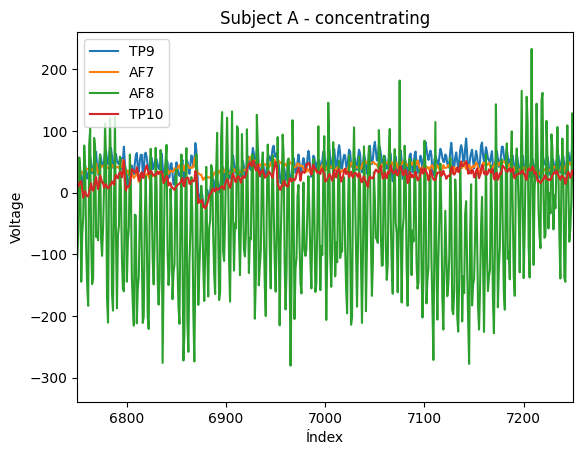

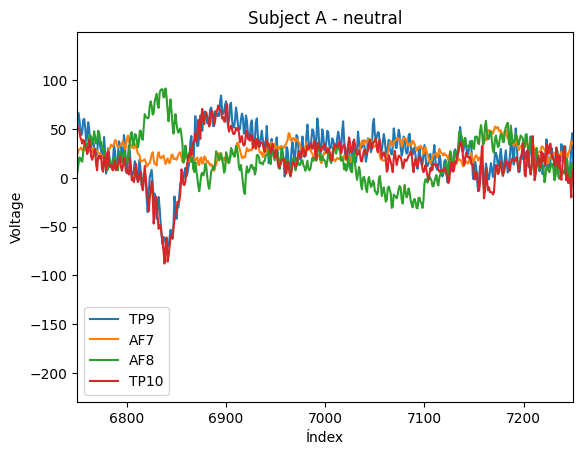

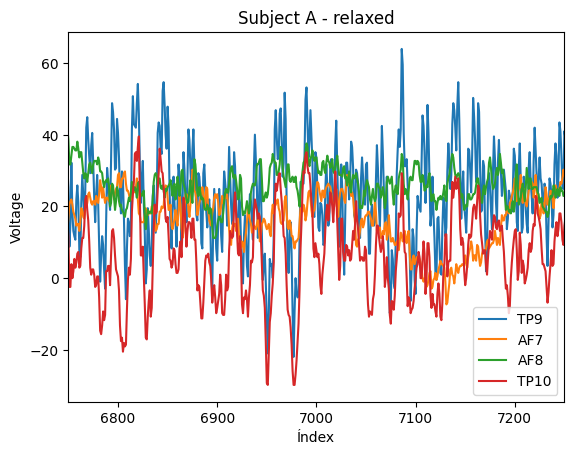

In [289]:
#Dataframe com os dados originais e não filtrados
dataframes_original = {}

data_path = os.getcwd()

fs=256 #Frequência de amostragem 256 Hz

for file in os.listdir(data_path):
    if file.endswith('1.csv'): #Escolher só os files que terminem com 1.csv
        if 'subject' in file:

            file_path = os.path.join(data_path, file)
            df = pd.read_csv(file_path) #df armazena os dados dos files
            
            data = df.iloc[6000:8000, 1:5]  # data fica com as colunas 2 a 5 - reduzir tamanho dos dados no tempo
            
            # Sujeito e estado conforme indicado no nome do file
            sujeito = file.split('subject')[1][0]
            estado = file.split('-')[1]

            key = (estado, sujeito)
            if key not in dataframes_original:
                dataframes_original[key] = []
            dataframes_original[key].append(data)

# Plot dos gráficos do sujeito A
for key, dfs in dataframes_original.items():
    if key[1] == 'a':
        plt.title(f'Subject A - {key[0]}')
        for channel in dfs:
            for state in channel.columns:
                plt.plot(channel.index, channel[state], label=state)
        plt.xlabel('Índex')
        plt.ylabel('Voltage')
        plt.xlim(6750,7250)
        plt.legend()
        plt.show()

**Filtering** (dataframes_filtrado)
- *High-pass*
- *Low-pass*
- *Notch*

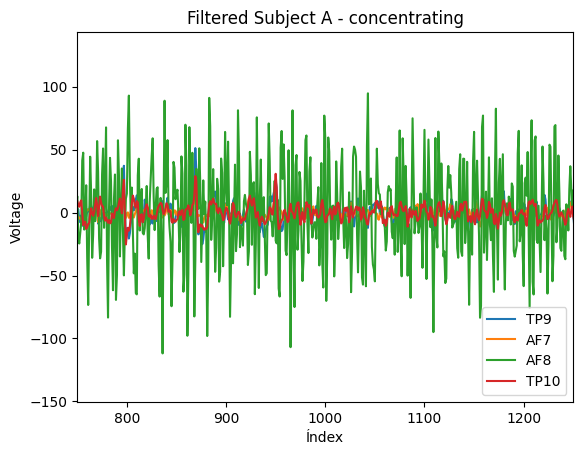

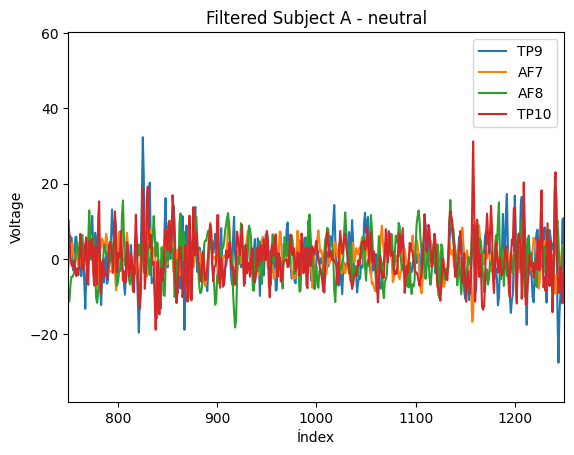

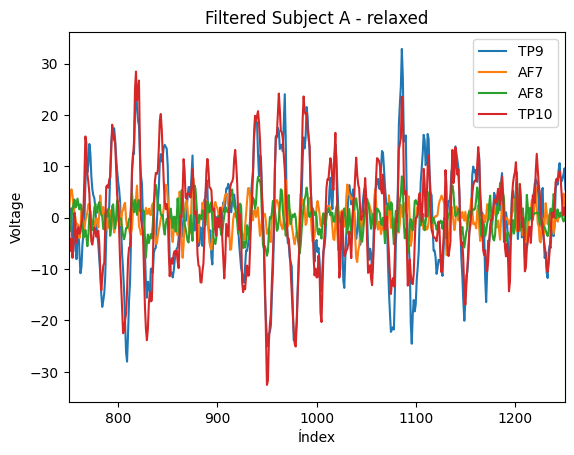

In [290]:
# Parâmetros dos filtros
notch_freq = 50 # Notch filter
quality_factor = 40
highcut = 90 # Low-pass
lowcut = 8 # High-pass
order = 8

# Aplicação dos parâmetros dos filtros
sos = signal.iirfilter(order, highcut, btype='lowpass', analog=False, ftype='butter', fs=256, output='sos')
b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, fs)
b_hp, a_hp = signal.butter(order, lowcut, btype='highpass', fs=256)

# Dataframe com os dados filtrados
dataframes_filtrado = {}

# Low pass e high pass
for key, dfs in dataframes_original.items():
    dataframes_filtrado[key] = []
    for df in dfs:
        df_filtrado_lp = pd.DataFrame(signal.sosfiltfilt(sos, df.values, axis=0), columns=df.columns)
        df_filtrado_lphp = pd.DataFrame(signal.filtfilt(b_hp, a_hp, df_filtrado_lp.values, axis=0), columns=df.columns)
        dataframes_filtrado[key].append(df_filtrado_lphp)

# Notch filter
for key, dfs in dataframes_filtrado.items():
    dataframes_filtrado[key] = []
    for df in dfs:
        filtered_channel=pd.DataFrame()
        for channel in df.columns:
            filtered_data = pd.DataFrame(signal.filtfilt(b_notch, a_notch, df[channel]))
            filtered_channel[channel]=filtered_data
        dataframes_filtrado[key].append(filtered_channel)

# Plot dos gráficos do sujeito A
for key, dfs in dataframes_filtrado.items():
    if key[1] == 'a':
        plt.title(f'Filtered Subject A - {key[0]}')
        for channel in dfs:
            for state in channel.columns:
                plt.plot(channel.index, channel[state], label=state)
        plt.xlabel('Índex')
        plt.xlim(750,1250)
        plt.ylabel('Voltage')
        plt.legend()
        plt.show()

**Feature extraction**

- *Multitaper method*

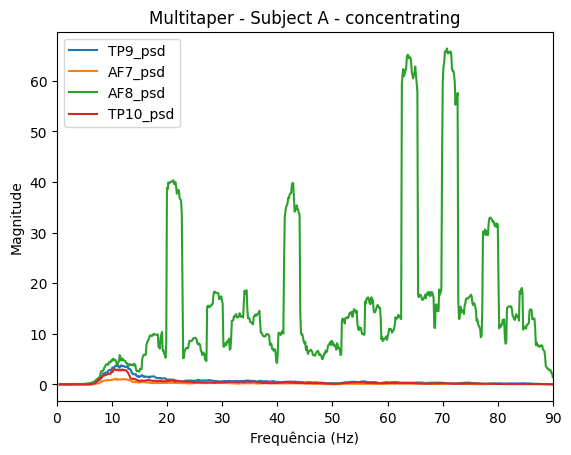

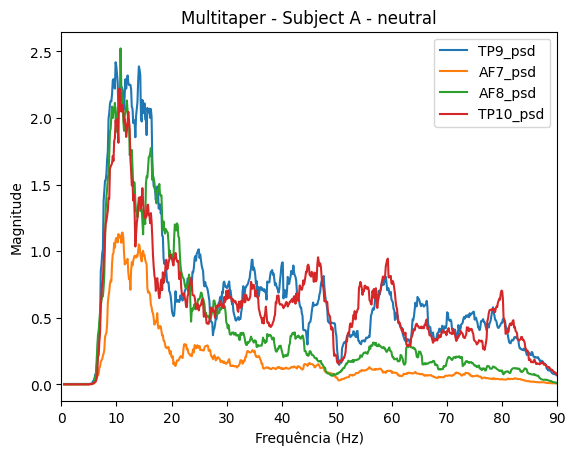

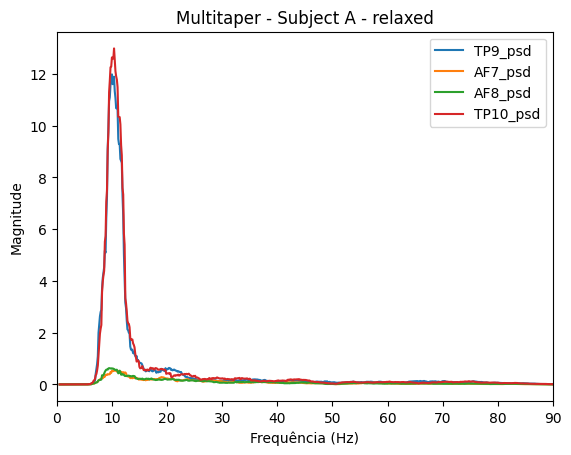

In [291]:
# Dataframe para os dados do multitaper
dataframes_multitaper = {}

for key, dfs in dataframes_filtrado.items():
    dataframes_multitaper[key] = []
    for df in dfs:
        df_multitaper = pd.DataFrame()
        for column in df.columns:
            psd_mt, freq_mt = psd_array_multitaper(df[column], fs, normalization='full', verbose=0, bandwidth=3)
            df_multitaper[f"{column}_freq"] = freq_mt
            df_multitaper[f"{column}_psd"] = psd_mt
        dataframes_multitaper[key].append(df_multitaper)

# Plot dos gráficos do sujeito A
for key, dfs in dataframes_multitaper.items():
    if key[1] == 'a':
        plt.title(f'Multitaper - Subject A - {key[0]}')
        for channel in dfs:
            for column in channel.columns[::2]:  # Seleciona apenas as colunas de frequência
                freq_column = column
                mag_column = column.replace("_freq", "_psd")
                freq_positive = channel[freq_column][channel[freq_column] > 0.5]  # Frequências maiores que 0,5 Hz
                mag_positive = channel[mag_column][channel[freq_column] > 0.5]    # Magnitudes correspondentes
                plt.plot(freq_positive, mag_positive, label=mag_column)
        plt.xlim(0, 90) 
        plt.xlabel('Frequência (Hz)')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.show()

**Feature selection**

Gerais:
- *Average power*
- *Mean*
- *Variance*
- *Skew*
- *Kurtosis*

Wave related:
- *Theta power*
- *Alpha power*
- *Beta power*
- *Gamma power*

In [292]:
# Features gerais
# Average power - area abaixo da curva do multitaper
def calculate_average_power(freq, magnitude, low_freq, high_freq):
    mask = (freq >= low_freq) & (freq <= high_freq)
    freq_interval = freq[mask]
    magnitude_interval = magnitude[mask]
    average_power = np.trapz(magnitude_interval, x=freq_interval)
    return average_power

# Outras estatísticas gerais
def summary_statistics(data):
    return np.mean(data), np.var(data), skew(data), kurtosis(data)

# Brainwaves frequency range
theta = (4, 8)
alpha = (8, 12)
beta = (12, 35)
gamma = (35,90)

# Extrair cada uma das features
def extract_features(df, method, channel_prefix):
    features = {}
    mag_column = f'{channel_prefix}_{method}'
    if mag_column in df.columns:
        mag_signal = df[mag_column]
        freqs = df[freq_column]
        
        # Average power de todo o sinal
        features[f'{channel_prefix}_{method}_average_power'] = calculate_average_power(freqs, mag_signal, lowcut, highcut)
        
        # Average power de cada brainwave de interesse
        theta_power = calculate_average_power(freqs, mag_signal, theta[0], theta[1])
        alpha_power = calculate_average_power(freqs, mag_signal, alpha[0], alpha[1])
        beta_power = calculate_average_power(freqs, mag_signal, beta[0], beta[1])
        gamma_power = calculate_average_power(freqs, mag_signal, gamma[0], gamma[1])
        
        # Guardar average power por banda
        features[f'{channel_prefix}_{method}_theta_power'] = theta_power
        features[f'{channel_prefix}_{method}_alpha_power'] = alpha_power
        features[f'{channel_prefix}_{method}_beta_power'] = beta_power
        features[f'{channel_prefix}_{method}_gamma_power'] = gamma_power

        # Features gerais
        features[f'{channel_prefix}_{method}_mean'] = mag_signal.mean()
        features[f'{channel_prefix}_{method}_var'] = mag_signal.var()
        features[f'{channel_prefix}_{method}_skew'] = skew(mag_signal)
        features[f'{channel_prefix}_{method}_kurtosis'] = kurtosis(mag_signal)

    return features


all_features_multi = []
            
# Extract features selected
for (condition, sujeito), dfs in dataframes_multitaper.items():
    for df in dfs:
        for channel_prefix in ['TP9', 'AF7', 'AF8', 'TP10']:
            channel_features = extract_features(df, 'psd', channel_prefix)
            all_features_multi.append({
                'condition': condition,
                'sujeito': sujeito,
                'channel': channel_prefix,
                **channel_features
            })

**Classification**

- *Support Vector Machine (SVM)*
- *Linear Discriminant Analysis (LDA)*
- *K-Nearest Neighbour (KNN)*
- *Random Forest*
- *Convolutional Neural Networks (CNN)*
- *EEGNet*

In [293]:
all_data = []
labels = []

# features gerais: _mean, _average_power, _var, _kurtosis, _skew
# features bands: _theta_power, _alpha_power, _beta_power, _gamma_power

# Escolher a feature
for item in all_features_multi:
    values = [item[key] for key in item.keys() if key.endswith('_gamma_power')]
    all_data.append(values)
    labels.append(item['condition'])

# Dados de entrada para o split do dataset em train e test
all_data = np.array(all_data)
labels = np.array(labels)
print("Shape dos dados de entrada:", all_data.shape)
print("Shape das labels de entrada:", labels.shape)

# Spli dos dados em train e test (80%, 20%)
x_train, x_test, y_train, y_test = train_test_split(all_data, labels, test_size=0.2, shuffle=True, random_state=42)
print("Shape dos dados de treino:", x_train.shape)
print("Shape dos dados de teste:", x_test.shape)
print("Shape das labels de treino:", y_train.shape)
print("Shape das labels de teste:", y_test.shape)

Shape dos dados de entrada: (48, 1)
Shape das labels de entrada: (48,)
Shape dos dados de treino: (38, 1)
Shape dos dados de teste: (10, 1)
Shape das labels de treino: (38,)
Shape das labels de teste: (10,)


Support Vector Machine (SVM)

In [294]:
# Grid search parameters
param_grid = {
    'C': [0.1, 1, 10, 100],  # the strength of the regularization is inversely proportional to C.
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # kernel type
    'degree': [1, 2, 3, 4]  # degree of the polynomial kernel function ('poly')
}

# Create SVM classifier
svm = SVC()

# Procura dos melhores parâmetros
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Cross-validation para o training set
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=3)
print("Cross validation accurancies:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Evaluate on the testing set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test set accuracy:", test_accuracy)

with open('classification_metrics.txt', 'a') as file:
    file.write("Support Vector Machine \n")
    file.write("Mean cross validation SVM: "+str(cv_scores.mean())+"\n")
    file.write("Test accuracy SVM: "+str(test_accuracy)+"\n")

Best Parameters: {'C': 0.1, 'degree': 1, 'kernel': 'linear'}
Cross validation accurancies: [0.46153846 0.46153846 0.83333333]
Mean CV accuracy: 0.5854700854700855
Test set accuracy: 0.5


Linear Discriminant Analysis (LDA)

In [295]:
# Grid search parameters
param_grid = {
    'solver': ['lsqr', 'eigen'],
    'shrinkage': [None, 'auto']  # covariance estimation
}

# Create LDA classifier
lda = LinearDiscriminantAnalysis()

# Procura dos melhores parâmetros
grid_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Cross-validation para o training set
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=3)
print("Cross validation accurancies:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

# Evaluate on the testing set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test set accuracy:", test_accuracy)

with open('classification_metrics.txt', 'a') as file:
    file.write("Linear Discriminant Analysis \n")
    file.write("Mean cross validation LDA: "+str(cv_scores.mean())+"\n")
    file.write("Test accuracy LDA: "+str(test_accuracy)+"\n")

Best Parameters: {'shrinkage': None, 'solver': 'lsqr'}
Cross validation accurancies: [0.46153846 0.38461538 0.58333333]
Mean CV accuracy: 0.4764957264957266
Test set accuracy: 0.2


K-Nearest Neighbour (KNN)

In [296]:
# Grid search parameters
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # number of neighbors
    'weights': ['uniform', 'distance'], 
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Create kNN classifier
knn = KNeighborsClassifier()

# Procura dos melhores parâmetros
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Cross-validation para o training set
cv_scores = cross_val_score(grid_search.best_estimator_, x_train, y_train, cv=3)
print("Cross validation accurancies:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

# Evaluate on the testing set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test set accuracy:", test_accuracy)

with open('classification_metrics.txt', 'a') as file:
    file.write("K Nearest Neighbour \n")
    file.write("Mean cross validation KNN: "+str(cv_scores.mean())+"\n")
    file.write("Test accuracy KNN: "+str(test_accuracy)+"\n")

Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
Cross validation accurancies: [0.53846154 0.46153846 0.75      ]
Mean accuracy: 0.5833333333333334
Test set accuracy: 0.4


Random Forest (RF)

In [297]:
# Grid search parameters
param_grid = {
    'n_estimators': [100, 200, 300],  # number of trees
    'max_depth': [None, 10, 20],  # maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # minimum number of samples required to be at a leaf node
}

# Create RF classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Procura dos melhores parâmetros
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search_rf.fit(x_train, y_train)
print("Best Parameters:", grid_search_rf.best_params_)

# Cross-validation para o training set
cv_scores = cross_val_score(grid_search_rf.best_estimator_, x_train, y_train, cv=3)
print("Cross validation accurancies:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

# Evaluate on the testing set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test set accuracy:", test_accuracy)

with open('classification_metrics.txt', 'a') as file:
    file.write("Random Forest \n")
    file.write("Mean cross validation RF: "+str(cv_scores.mean())+"\n")
    file.write("Test accuracy RF: "+str(test_accuracy)+"\n")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Cross validation accurancies: [0.53846154 0.38461538 0.58333333]
Mean accuracy: 0.5021367521367521
Test set accuracy: 0.4


*Split dataset to CNN and EEGNet*

In [298]:
# Pre-processing data
all_data_cnn = []
labels_cnn = []

# Percorrer o dataframe after pre-processing
for key, dfs in dataframes_filtrado.items():
    estado = key[0] 
    for df in dfs:
        all_data_cnn.append(df.values)
        labels_cnn.append(estado)

# Converter listas para arrays numpy
all_data_cnn = np.array(all_data_cnn)
labels_cnn = np.array(labels_cnn)
print("All data CNN shape:", all_data_cnn.shape)

# Definir input shape para dados 2D
input_shape = all_data_cnn.shape[1:] 
print("Input shape for 2D data:", input_shape)

# Label pre-processing
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_cnn)
num_classes = len(np.unique(labels_cnn))
labels_one_hot = to_categorical(labels_encoded, num_classes=num_classes)

# 5-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

cnn_accuracies = []
eegnet_accuracies = []

All data CNN shape: (12, 2000, 4)
Input shape for 2D data: (2000, 4)


Convolutional Neural Networks (CNN)

In [299]:
fold = 1
with open('classification_metrics.txt', 'a') as file:
      file.write("Convolutional Neural Networks \n")

for train_index, test_index in kf.split(all_data_cnn):
    x_train_cnn, x_test_cnn = all_data_cnn[train_index], all_data_cnn[test_index]
    y_train_cnn, y_test_cnn = labels_one_hot[train_index], labels_one_hot[test_index]

    # Split training data into training and validation set
    x_train_cnn, x_val_cnn, y_train_cnn, y_val_cnn = train_test_split(x_train_cnn, y_train_cnn, test_size=0.25, random_state=42)

    model_cnn = models.Sequential([
        layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Conv1D(256, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model_cnn.compile(optimizer='adam',
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

    # Fit the model
    history_cnn = model_cnn.fit(x_train_cnn, y_train_cnn, epochs=40, batch_size=32, validation_data=(x_val_cnn, y_val_cnn))

    # Evaluate the model
    test_loss, test_acc = model_cnn.evaluate(x_test_cnn, y_test_cnn)
    cnn_accuracies.append(test_acc)

    fold += 1

with open('classification_metrics.txt', 'a') as file:
    file.write("Test set accuracy: " + str(np.mean(cnn_accuracies)) + "\n")

c:\Users\beatr\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1667 - loss: 2.6745 - val_accuracy: 0.0000e+00 - val_loss: 176.8860
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.5000 - loss: 81.5504 - val_accuracy: 0.5000 - val_loss: 47.8371
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.1667 - loss: 65.9398 - val_accuracy: 0.5000 - val_loss: 21.7493
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5000 - loss: 27.6463 - val_accuracy: 0.0000e+00 - val_loss: 17.6764
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8333 - loss: 0.9188 - val_accuracy: 0.5000 - val_loss: 126.9482
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8333 - loss: 24.6674 - val_accuracy: 0.5000 - val_loss: 146.6832
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6667 - loss: 10.1860 - val_accuracy: 0.5000 - val_loss: 129.4955
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8333 - loss: 2.0361 - val_accurac

EEGNet

In [300]:
fold = 1
with open('classification_metrics.txt', 'a') as file:
      file.write("EEGNet \n")

for train_index, test_index in kf.split(all_data_cnn):
    x_train_cnn, x_test_cnn = all_data_cnn[train_index], all_data_cnn[test_index]
    y_train_cnn, y_test_cnn = labels_one_hot[train_index], labels_one_hot[test_index]

    # Split training data into training and validation set
    x_train_cnn, x_val_cnn, y_train_cnn, y_val_cnn = train_test_split(x_train_cnn, y_train_cnn, test_size=0.25, random_state=42)

    model_eegnet = models.Sequential([
        layers.Conv1D(16, 3, padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.DepthwiseConv1D(3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('elu'),
        layers.AveragePooling1D(pool_size=2),
        layers.Dropout(0.25),
        layers.SeparableConv1D(32, 3, padding='same'),
        layers.BatchNormalization(),
        layers.Activation('elu'),
        layers.AveragePooling1D(pool_size=2),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('elu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model_eegnet.compile(optimizer='adam',
                         loss='categorical_crossentropy', 
                         metrics=['accuracy'])

    # Fit the model
    history_eegnet = model_eegnet.fit(x_train_cnn, y_train_cnn, epochs=40, batch_size=32, validation_data=(x_val_cnn, y_val_cnn))

    # Evaluate the model
    test_loss, test_acc = model_eegnet.evaluate(x_test_cnn, y_test_cnn)
    eegnet_accuracies.append(test_acc)
    print(f'Fold {fold} - EEGNet Test accuracy:', test_acc)

    fold += 1

with open('classification_metrics.txt', 'a') as file:
        file.write("Test set accuracy: " + str(np.mean(eegnet_accuracies)) + "\n")

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5000 - loss: 1.1305 - val_accuracy: 0.5000 - val_loss: 0.9970
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8333 - loss: 0.4802 - val_accuracy: 0.5000 - val_loss: 0.9388
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 1.0000 - loss: 0.0485 - val_accuracy: 0.5000 - val_loss: 0.9825
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 1.0000 - loss: 0.0921 - val_accuracy: 0.5000 - val_loss: 1.0058
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 1.0000 - loss: 0.1012 - val_accuracy: 0.5000 - val_loss: 1.0072
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.0174 - val_accuracy: 0.5000 - val_loss: 0.9974
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0248 - val_accuracy: 0.5000 - val_loss: 0.9844
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 0.5000 - val_loss: 0.9703